# Importing Libraries

In [1]:
!pip install tensorflow==2.9.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 88.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 89.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 37.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 24.3.25
    Uninstalling flatbuffers-24.3.25:
      Successfully uninstalled flatbuffers-24.3.25
  Attempting uninstall:

In [2]:
# import system libraries
import os
import PIL
from PIL import Image
import cv2
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# import Deep Learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.efficientnet import EfficientNetB3

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Data Preprocessing

## Read Data and store it in dataframe

In [3]:
data_dir = '/kaggle/input/flowers-dataset/flower_photos'
filepaths = []
labels = []

folders = os.listdir(data_dir)
for fold in folders:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
        
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

In [4]:
df

filepaths     labels
0     /kaggle/input/flowers-dataset/flower_photos/da...  dandelion
1     /kaggle/input/flowers-dataset/flower_photos/da...  dandelion
2     /kaggle/input/flowers-dataset/flower_photos/da...  dandelion
3     /kaggle/input/flowers-dataset/flower_photos/da...  dandelion
4     /kaggle/input/flowers-dataset/flower_photos/da...  dandelion
...                                                 ...        ...
3665  /kaggle/input/flowers-dataset/flower_photos/tu...     tulips
3666  /kaggle/input/flowers-dataset/flower_photos/tu...     tulips
3667  /kaggle/input/flowers-dataset/flower_photos/tu...     tulips
3668  /kaggle/input/flowers-dataset/flower_photos/tu...     tulips
3669  /kaggle/input/flowers-dataset/flower_photos/tu...     tulips

[3670 rows x 2 columns]

In [5]:
df['labels'].value_counts()

labels
dandelion     898
tulips        799
sunflowers    699
roses         641
daisy         633
Name: count, dtype: int64

## Spliting the data into Training and Testing

In [6]:
# Splitting dataset
strat = df['labels']
train_df, dummy_df = train_test_split(df, test_size=.3, random_state=123, stratify=strat, shuffle=True)

# valid and test dataframe
strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df, test_size=.5, random_state=123, stratify=strat, shuffle=True)

In [7]:
train_df

filepaths     labels
3028  /kaggle/input/flowers-dataset/flower_photos/tu...     tulips
2407  /kaggle/input/flowers-dataset/flower_photos/ro...      roses
893   /kaggle/input/flowers-dataset/flower_photos/da...  dandelion
2677  /kaggle/input/flowers-dataset/flower_photos/ro...      roses
3532  /kaggle/input/flowers-dataset/flower_photos/tu...     tulips
...                                                 ...        ...
2049  /kaggle/input/flowers-dataset/flower_photos/da...      daisy
2519  /kaggle/input/flowers-dataset/flower_photos/ro...      roses
2099  /kaggle/input/flowers-dataset/flower_photos/da...      daisy
3054  /kaggle/input/flowers-dataset/flower_photos/tu...     tulips
3362  /kaggle/input/flowers-dataset/flower_photos/tu...     tulips

[2569 rows x 2 columns]

In [8]:
print(f"Number of Training dataset: {len(train_df)}\nNumber of Validation dataset: {len(valid_df)}\nNumber of Testing dataset: {len(test_df)}")

Number of Training dataset: 2569
Number of Validation dataset: 550
Number of Testing dataset: 551


## Create image data generator

In [9]:
# crobed image size
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 2569 validated image filenames belonging to 5 classes.
Found 550 validated image filenames belonging to 5 classes.
Found 551 validated image filenames belonging to 5 classes.


## Show sample from train data

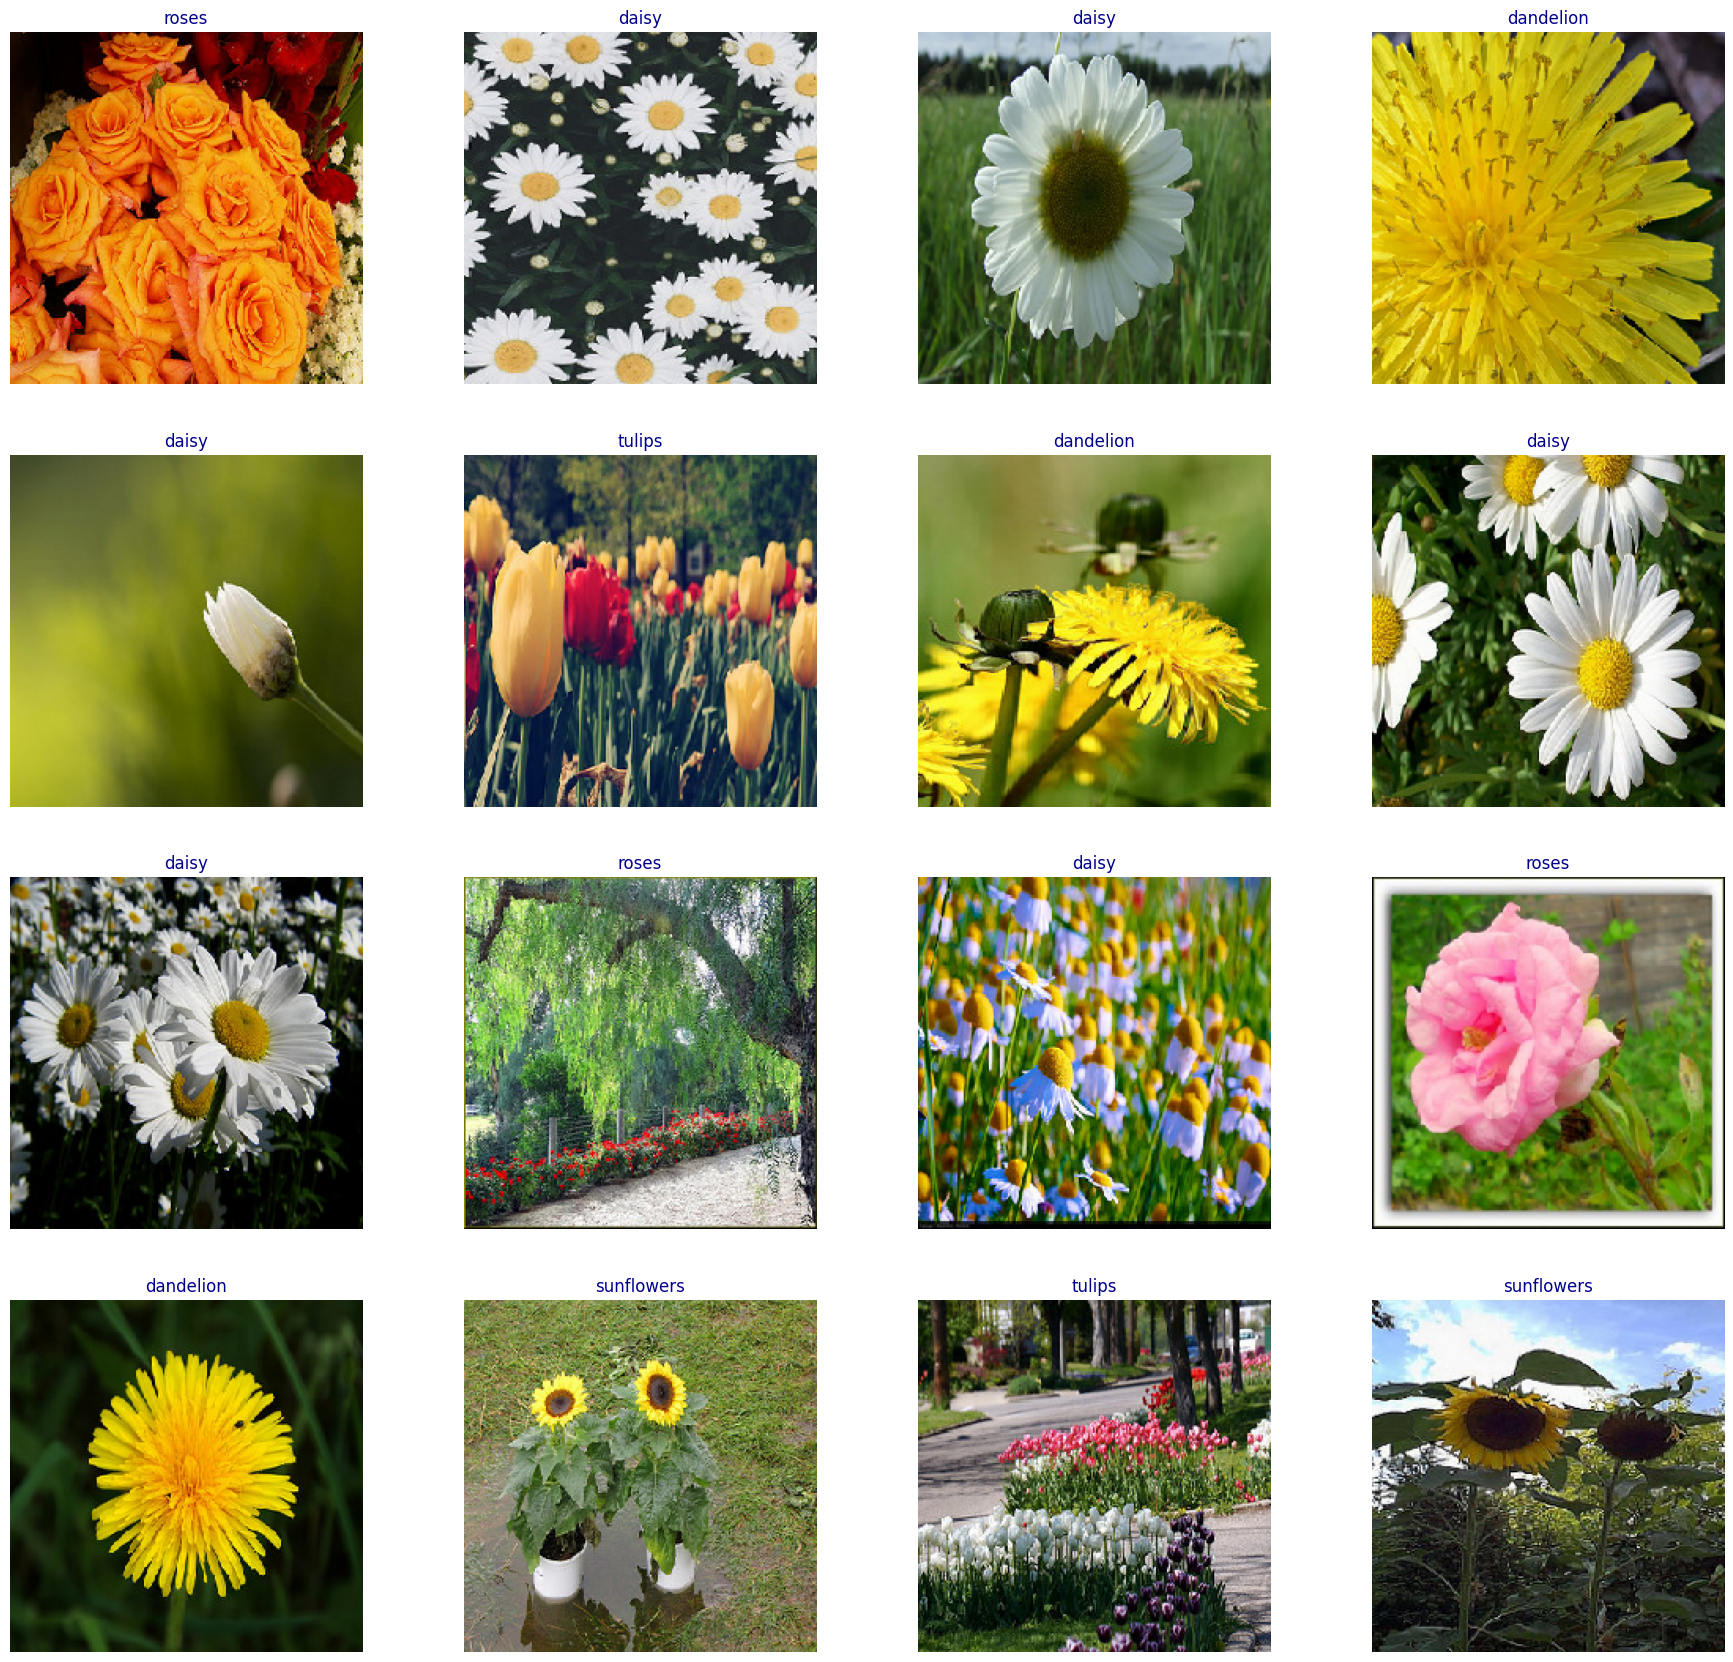

In [10]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i+1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'darkblue', fontsize= 12)
    plt.axis('off')
plt.show()

# Model Structure

## Generic Model Creation

In [11]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# we will use efficientnetb3 from EfficientNet family.
base_model = EfficientNetB3(include_top= False, weights='imagenet',
                           input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(),
    
    Dense(256, activation='relu'),
    Dropout(rate=.45, seed=123),
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate= .0001), loss = 'categorical_crossentropy', 
              metrics=['acc', tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

43941136/43941136 [==============================] - 0s 0us/step


## Train Model

In [13]:
early_stopping = EarlyStopping(
    patience=10,
    min_delta=0,
    mode=min,
    monitor='val_loss',
    verbose=0,
    restore_best_weights=True,
    baseline=None
)

In [14]:
history = model.fit(train_gen, epochs=30, verbose=1, validation_data=valid_gen, 
                    validation_steps= None, shuffle=False, callbacks=early_stopping)

Epoch 1/30
81/81 [==============================] - 769s 9s/step - loss: 1.5248 - acc: 0.4511 - precision: 0.5169 - recall: 0.3562 - auc: 0.7542 - val_loss: 0.7132 - val_acc: 0.7364 - val_precision: 0.7961 - val_recall: 0.6600 - val_auc: 0.9351
Epoch 2/30
81/81 [==============================] - 747s 9s/step - loss: 0.8607 - acc: 0.6699 - precision: 0.7537 - recall: 0.5991 - auc: 0.9084 - val_loss: 0.4932 - val_acc: 0.8109 - val_precision: 0.8794 - val_recall: 0.7691 - val_auc: 0.9695
Epoch 3/30
81/81 [==============================] - 743s 9s/step - loss: 0.6411 - acc: 0.7653 - precision: 0.8223 - recall: 0.7135 - auc: 0.9483 - val_loss: 0.4247 - val_acc: 0.8509 - val_precision: 0.8972 - val_recall: 0.8091 - val_auc: 0.9771
Epoch 4/30
81/81 [==============================] - 749s 9s/step - loss: 0.5338 - acc: 0.8093 - precision: 0.8592 - recall: 0.7649 - auc: 0.9635 - val_loss: 0.3722 - val_acc: 0.8782 - val_precision: 0.9069 - val_recall: 0.8327 - val_auc: 0.9823
Epoch 5/30
81/81 [==

## Display model performance

In [15]:
# Define needed variables
tr_acc = history.history['acc']
tr_loss = history.history['loss']
tr_perc = history.history['precision']
tr_recall = history.history['recall']
tr_auc = history.history['auc']

val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
val_perc = history.history['val_precision']
val_recall = history.history['val_recall']
val_auc = history.history['val_auc']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

index_perc = np.argmax(val_perc)
perc_highest = val_perc[index_perc]

index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

index_auc = np.argmax(val_auc)
auc_highest = val_auc[index_auc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
perc_label = f'best epoch= {str(index_perc + 1)}'
recall_label = f'best epoch= {str(index_recall + 1)}'
auc_label = f'best epoch= {str(index_auc + 1)}'

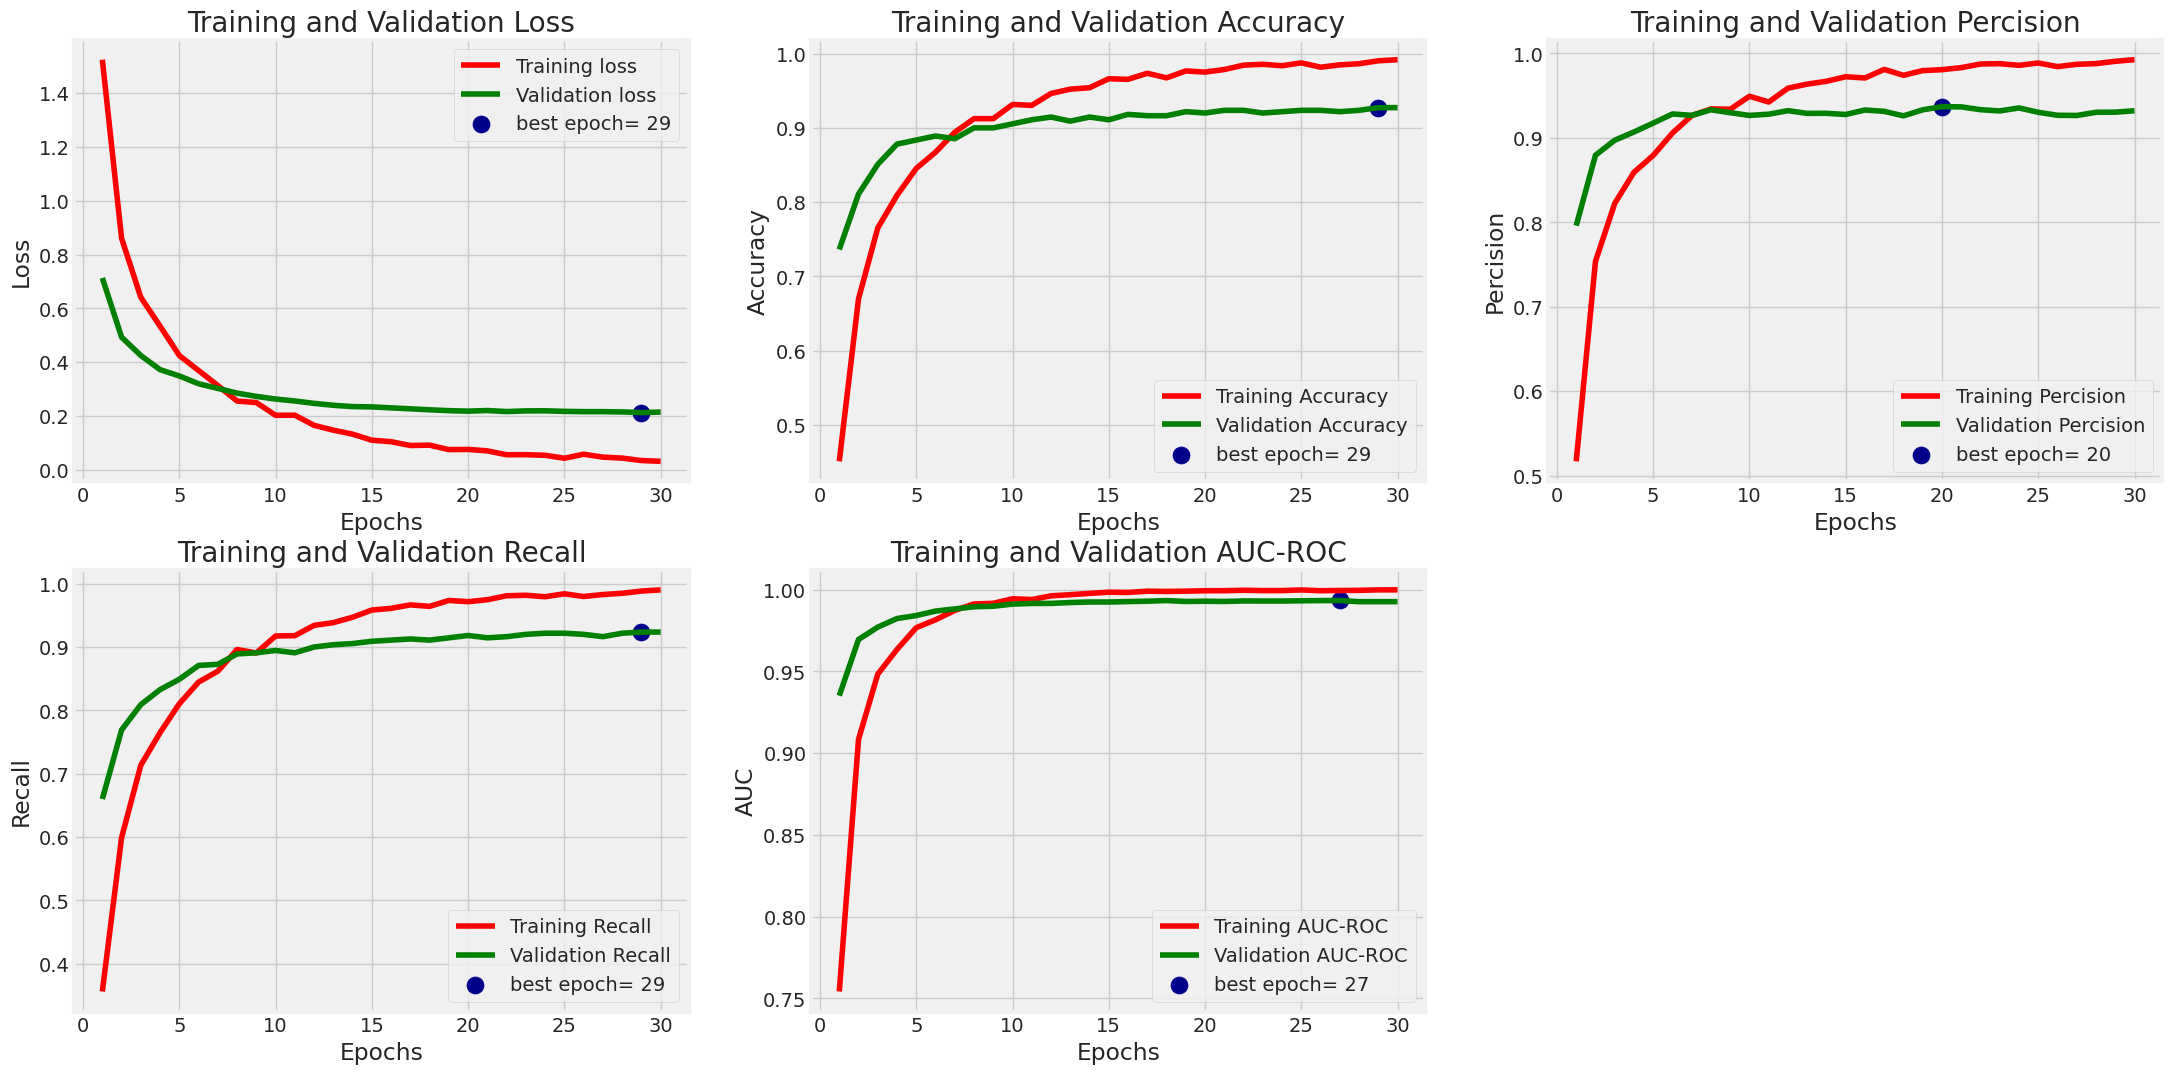

In [16]:
# Plot training history
plt.figure(figsize= (24, 12))
plt.style.use('fivethirtyeight')

plt.subplot(2, 3, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'darkblue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'darkblue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(Epochs, tr_perc, 'r', label= 'Training Percision')
plt.plot(Epochs, val_perc, 'g', label= 'Validation Percision')
plt.scatter(index_perc + 1 , perc_highest, s= 150, c= 'darkblue', label= perc_label)
plt.title('Training and Validation Percision')
plt.xlabel('Epochs')
plt.ylabel('Percision')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(Epochs, tr_recall, 'r', label= 'Training Recall')
plt.plot(Epochs, val_recall, 'g', label= 'Validation Recall')
plt.scatter(index_recall + 1 , recall_highest, s= 150, c= 'darkblue', label= recall_label)
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(Epochs, tr_auc, 'r', label= 'Training AUC-ROC')
plt.plot(Epochs, val_auc, 'g', label= 'Validation AUC-ROC')
plt.scatter(index_auc + 1 , auc_highest, s= 150, c= 'darkblue', label= auc_label)
plt.title('Training and Validation AUC-ROC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout
plt.show()

# Evaluate model

In [17]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

18/18 [==============================] - 34s 2s/step - loss: 0.2469 - acc: 0.9238 - precision: 0.9352 - recall: 0.9165 - auc: 0.9904
Train Loss:  0.0010623607086017728
Train Accuracy:  1.0
--------------------
Validation Loss:  0.21465791761875153
Validation Accuracy:  0.9272727370262146
--------------------
Test Loss:  0.2469019740819931
Test Accuracy:  0.9237749576568604


# Get Predictions

In [18]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

18/18 [==============================] - 35s 2s/step


## Confusion Matrics and Classification Report

In [19]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

In [20]:
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

array([[ 89,   3,   1,   2,   0],
       [  2, 130,   1,   2,   0],
       [  1,   4,  86,   0,   5],
       [  2,   1,   2,  99,   1],
       [  2,   2,   9,   2, 105]])

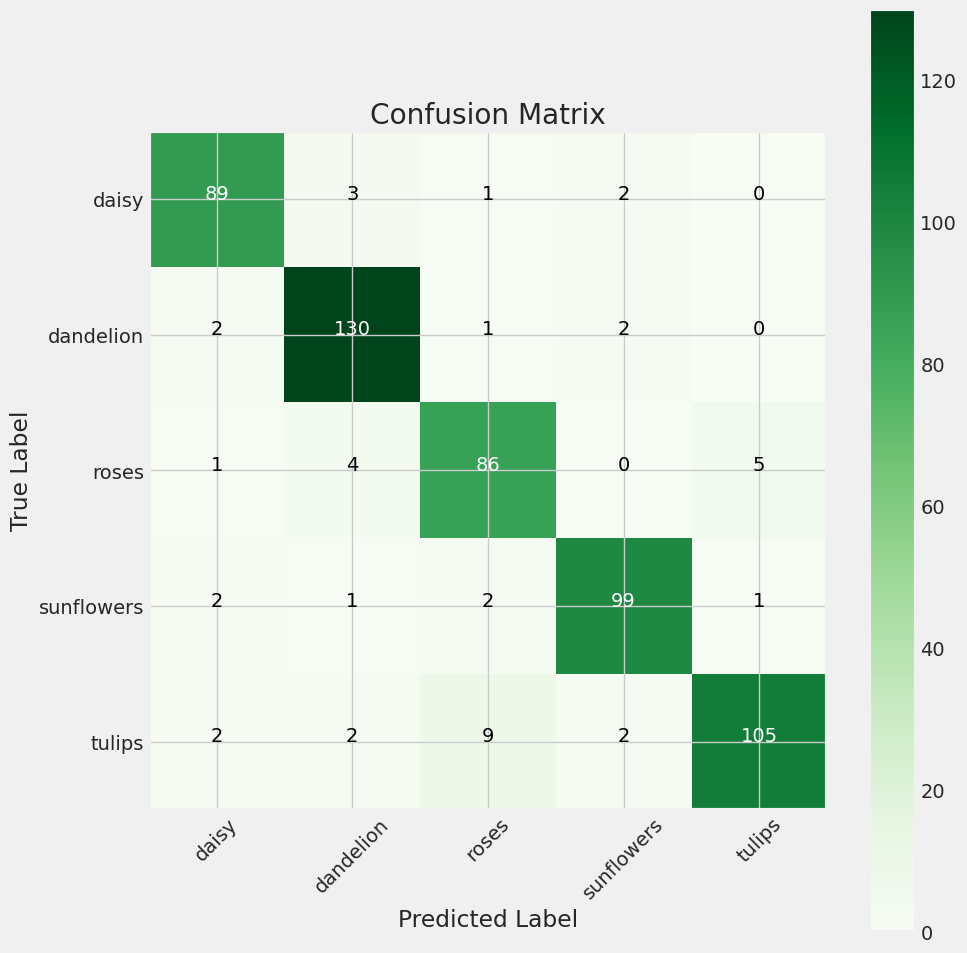

In [25]:
plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Greens)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [22]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

       daisy       0.93      0.94      0.93        95
   dandelion       0.93      0.96      0.95       135
       roses       0.87      0.90      0.88        96
  sunflowers       0.94      0.94      0.94       105
      tulips       0.95      0.88      0.91       120

    accuracy                           0.92       551
   macro avg       0.92      0.92      0.92       551
weighted avg       0.92      0.92      0.92       551



# Save model

In [23]:
#Save the model
model.save('Flower EfficientNetB3 Model.h5')